# Figure: model comparison

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import cortex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from scipy import stats

from util import plot
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
encmodel = "encoding_trialmot6"
cache = encmodel.split("/")[-1]
encmodel, cache

('encoding_trialmot6', 'encoding_trialmot6')

# Load results

In [4]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']
models = [models[2]]

In [5]:
results = defaultdict(list)
for modelname in models:
    respath = Path(
        root=encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            for key in ["cv_scores_prod", "cv_scores_comp"]:  # , "cv_scores"]:
                # all_results[(modelname, key)].append(f[key][...])
                results[key].append(f[key][...])

100%|██████████| 58/58 [00:01<00:00, 29.21it/s]


In [6]:
# scores without splitting into prod/comp time points
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_lang = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean(1)
all_scores_prod.shape

(58, 5, 3, 81924)

In [7]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_lang = avg_scores_prod[-2] + avg_scores_comp[-1]
avg_scores_prod.shape

(3, 81924)

## Test for significance

In [8]:
fgmask = get_brainmask()


def ttest_sig(
    values: np.ndarray,
    popmean: int = 0,
    correlations: bool = True,
    alternative: str = "two-sided",
    alpha: float = 0.01,
    method="bonf",
):
    if correlations:
        values = np.arctanh(values)

    ttest = stats.ttest_1samp(values, popmean=popmean, alternative=alternative)

    pvalues = ttest.pvalue
    multiple = multipletests(pvalues[fgmask], alpha=alpha, method=method)

    reject = np.zeros_like(pvalues, dtype=bool)
    reject[*fgmask.nonzero()] = multiple[0]

    return reject

In [15]:
sigmask = ttest_sig(all_scores_lang, method='bonf', alpha=0.05)
sigmask = ttest_sig(all_scores_lang, method='fdr_bh', alpha=0.05)
sigmask.sum()

11227

# Plot LLM encoding performance

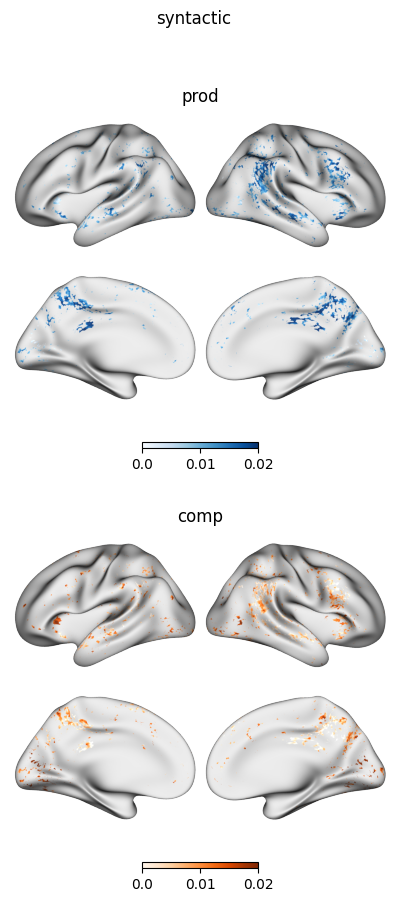

In [16]:
values1 = avg_scores_prod[-2]#.copy()
values2 = avg_scores_comp[-1]#.copy()

brainmask = ~sigmask
# brainmask = None

fig, axes = plt.subplots(2, 1, figsize=(5, 10))
plot.surface_plot(
    values1, threshold=brainmask, fig=fig, ax=axes[0], vmin=0, cmap="Blues", title="prod"
)
plot.surface_plot(
    values2,
    threshold=brainmask,
    fig=fig,
    ax=axes[1],
    vmin=0,
    cmap="Oranges",
    title="comp",
)
fig.suptitle(modelname)
fig.show()

## flatmap

In [10]:
values1[~sigmask] = np.nan
values2[~sigmask] = np.nan
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:4084911): glibmm-WARNING **: 15:36:04.103: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.


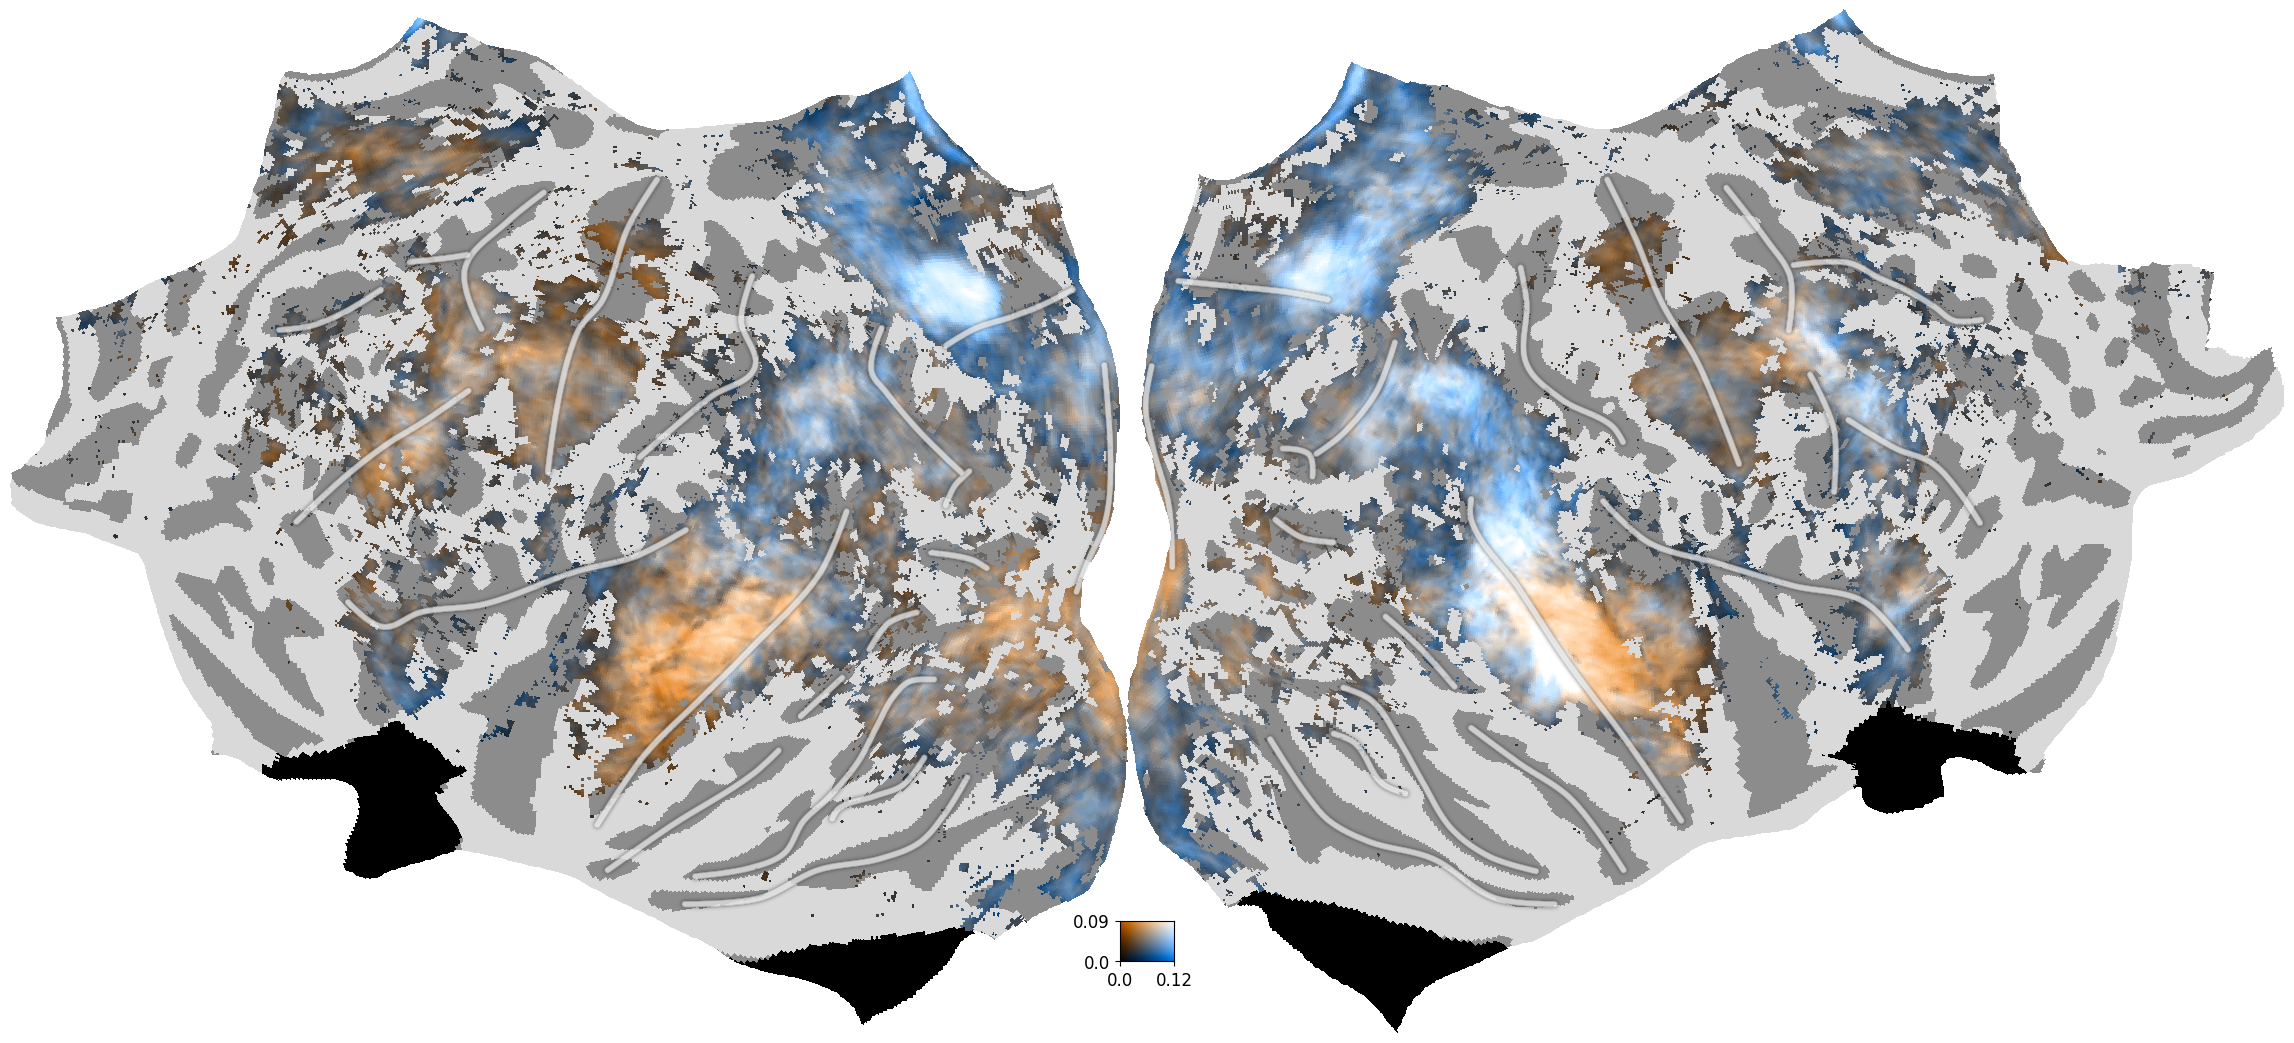

In [11]:
fig = cortex.quickflat.make_figure(
    volume,
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
    curvature_brightness=0.7,
    curvature_contrast=0.3,
)